# Random Forest
This page goes over training of a Random Forest Ensamble model, evaluating it with `GridSearchCV`, and peforming hyperparameter tuning for more perfect fit.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, zero_one_loss, classification_report

Our First Task is to Define Headers


In [35]:
def define_columns(df: pd.DataFrame) -> tuple[list[str], list[str], list[str]]:
    # Things that belong to strongly predictions, we just remove this
    exclusion_list = ['num_outbound_cmds', 'attack_category', 'success_pred', 'attack_type']
    # Define nominal and binary columns
    nominal = ['protocol_type', 'service', 'flag']
    binary = ['land', 'logged_in', 'root_shell', 'su_attempted', 'is_host_login', 'is_guest_login']

    # Define numeric columns dynamically based on the dataframe
    numeric = [col for col in df.columns if col not in nominal + binary + exclusion_list]

    return nominal, binary, numeric

Below Code provides us with a standard function to evaluate our model:

In [36]:
def print_score(classifier_name: str, y_test_data, y_pred_data):
    print(f"\n{classifier_name}\n")
    print(f"Zero One Loss: {zero_one_loss(y_test_data, y_pred_data):.4f}")
    print(f"Accuracy: {accuracy_score(y_test_data, y_pred_data):.2f}")
    print("\nClassification Report:\n", classification_report(y_test_data, y_pred_data))
    print("\nConfusion Matrix:\n", confusion_matrix(y_test_data, y_pred_data))

Fixing Problems with existing data

In [37]:
def preprocess_data(df: pd.DataFrame) -> tuple:
    """Prepare and preprocess the dataset."""
    try:
        df = df.copy()

        # Data cleaning
        df['su_attempted'] = df['su_attempted'].replace({2: 0}, inplace=False)

        # Define columns
        nominal, binary, numeric = define_columns(df)

        return df[nominal + numeric + binary], df['attack_category']
    except Exception as e:
        raise ValueError(f"Error in preprocessing: {str(e)}")

Call the Preprocess Method

In [ ]:
# Load data with error handling
df = pd.read_csv('./data/kdd_merged.csv')

# Preprocess data
X, y = preprocess_data(df)

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
nominal, binary, numeric = define_columns(df)

# Define preprocessing pipeline
preprocessor = ColumnTransformer([
    ('nominal', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal),
    ('numeric', StandardScaler(), numeric),
    ('binary', 'passthrough', binary)
])

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],  # Number of trees
    'classifier__max_depth': [10, 20, None],  # Maximum depth of trees
    'classifier__min_samples_split': [2, 5],  # Minimum samples to split
    'classifier__min_samples_leaf': [1, 2]    # Minimum samples in leaf
}

# Stratified cross-validation
sss = StratifiedShuffleSplit(n_splits=4, test_size=0.3, random_state=42)
scores = []

# Create GridSearchCV object
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=3,  # Inner cross-validation folds
    scoring='accuracy',
    n_jobs=-1,  # Use all available CPU cores
    verbose=1
)

# Training and evaluation loop
for fold, (train_index, test_index) in enumerate(sss.split(X, y_encoded), 1):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_encoded[train_index], y_encoded[test_index]

    try:
        # Fit GridSearchCV
        grid_search.fit(X_train, y_train)

        # Get best parameters for this fold
        print(f"\nBest parameters for fold {fold}: {grid_search.best_params_}")

        # Predict using the best model
        pred = grid_search.predict(X_test)
        scores.append(accuracy_score(y_test, pred))
        print_score(f"Random Forest - Fold {fold}", y_test, pred)

    except Exception as e:
        print(f"Error in fold {fold}: {str(e)}")
        continue

# Final summary
print("\nCross-validation scores:", scores)
print(f"Mean accuracy: {np.mean(scores):.4f} (+/- {np.std(scores) * 2:.4f})")
print(f"Overall best parameters from last fold: {grid_search.best_params_}")

# Optional: Save the best model from the final fold
import joblib
joblib.dump(grid_search.best_estimator_, 'best_rf_model.pkl')

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best parameters for fold 1: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}

Random Forest - Fold 1

Zero One Loss: 0.0048
Accuracy: 1.00

Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     23117
           1       1.00      1.00      1.00     16069
           2       0.99      1.00      0.99      4224
           3       1.00      0.96      0.98      1071
           4       0.89      0.63      0.73        75

    accuracy                           1.00     44556
   macro avg       0.97      0.91      0.94     44556
weighted avg       1.00      1.00      1.00     44556


Confusion Matrix:
 [[23048    33    30     3     3]
 [   54 16012     3     0     0]
 [   12     0  4212     0     0]
 [   41     0     2  1025     3]
 [   25     0     1     2    47]]
Fitting 3 fo

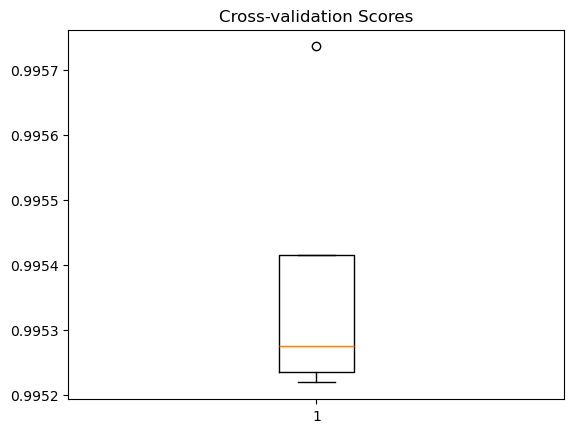

In [33]:
import matplotlib.pyplot as plt
plt.boxplot(scores)
plt.title('Cross-validation Scores')
plt.show()